# Project: Surface Brightness Profile & Sérsic Fit for NGC 4467 (SDSS DR19, g-band)
### Goal: Build a quantitative 1D surface-brightness (SB) profile for the elliptical galaxy NGC 4467 from an SDSS corrected frame (g-band), fit a Sérsic model with free index $n$, and report:
- Effective surface brightness $\mu_e$ (mag arcsec$^{-2}$)
- Effective radius $R_e$ (arcsec and kpc)
- Sérsic index $n$
- Goodness of fit (e.g., reduced $\chi^2$, residual trends)
- Total apparent magnitude $m_g$ and absolute magnitude $M_g$
- Central surface brightness $\mu_0$ (mag arcsec$^{-2}$)
- A brief Hubble-type estimate (e.g., E2/E3) from the isophote geometry
#### Data & units.
- SDSS DR19 corrected frames are calibrated in nanomaggies per pixel.
- Pixel scale: $s = 0.396\ \text{arcsec/pixel}$.
- Magnitude conversion (Pogson): $m = 22.5 - 2.5\log_{10}(\text{flux in nanomaggies})$.
- SB in mag arcsec$^{-2}$ requires converting per pixel flux to per arcsec$^2$ via division by $s^2$.
#### Method overview.
- Load & inspect the image; note NGC 4467 may be off-center and near the bright halo of M49 (NGC 4472)—background handling and masking matter.
- Estimate & subtract a smooth background (SEP) to remove large-scale gradients.
- Detect sources (SEP), get a first guess of the galaxy center, and mask stars/compact sources that would bias isophote fitting.
- (Optional) Light smoothing to stabilize isophote solutions.
- Elliptical-isophote fitting (Photutils Ellipse) from $r \gtrsim 1''$ out to $\sim 100''$ where S/N allows.
- Convert to SB: nanomaggies/pixel $\rightarrow$ nanomaggies/arcsec$^2$ $\rightarrow$ mag arcsec$^{-2}$.
- Fit Sérsic model in magnitude space:

- Assess fit (overlay + residuals), derive $\mu_e, R_e, n$, compute $\mu_0=\mu_e-1.0857,b_n$.
- Measure total flux with a large elliptical aperture; convert to $m_g$, then to $M_g$ with your adopted distance.
- Convert $R_e$ to kpc using $1'' = 0.004848,D_{\rm Mpc}\ \text{kpc}$.
#### Deliverables.
- Figure: SB profile (mag arcsec$^{-2}$ vs. arcsec) with Sérsic fit overlaid; y-axis inverted.
- Table/paragraph with $\mu_e, R_e$ (arcsec, kpc), $n$, $\chi^2_\nu$, $\mu_0$, $m_g$, $M_g$.
- Brief Hubble-type classification and notes on masking/background choices.



[NGC 4467](https://skyserver.sdss.org/dr19/VisualTools/explore/summary?name=ngc%204467&ra=187.3760197403200&dec=+07.9928537142600)

### 1. Imports & Global Settings

In [10]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.convolution import Gaussian2DKernel, convolve
import matplotlib.pyplot as plt

import sep
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils.aperture import EllipticalAperture

### 2.  Load FITS & quick-look display
- Opens the SDSS g-band corrected frame FITS.
- Extracts the primary image and header; builds a WCS (if present).
- Displays a zscaled image to inspect centering, neighbors, and artifacts.

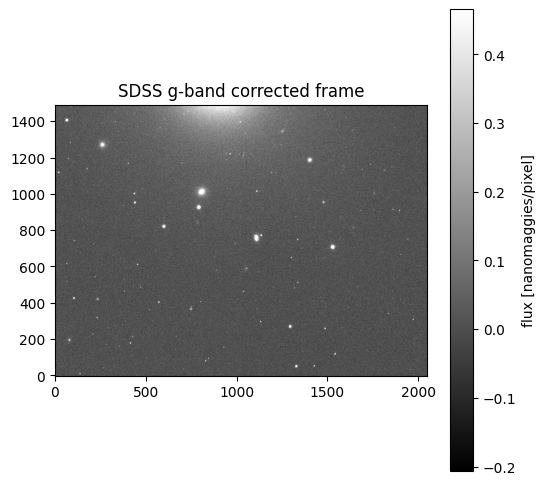

In [11]:
fits_path = Path("C:/Users/andre/Desktop/Astro/GalacticAstronomy/HW1/frame-g-002168-5-0147.fits")
hdul = fits.open(sorted(Path('.').glob('*.fits'))[0])
img = hdul[0].data.astype(np.float32)
hdr = hdul[0].header
wcs = WCS(hdr)
hdul.close()

# quick display
norm = ImageNormalize(img, interval=ZScaleInterval())
plt.figure(figsize=(6,6))
plt.imshow(img, origin='lower', cmap='gray', norm=norm)
plt.title("SDSS g-band corrected frame")
plt.colorbar(label='flux [nanomaggies/pixel]')
plt.show()

### 3. Background estimation & subtraction
- Computes a smooth background map and RMS (noise) with SEP.
- Subtracts the background to produce a flattened image.
- Shows a 3-panel figure: original, background, and background-subtracted.

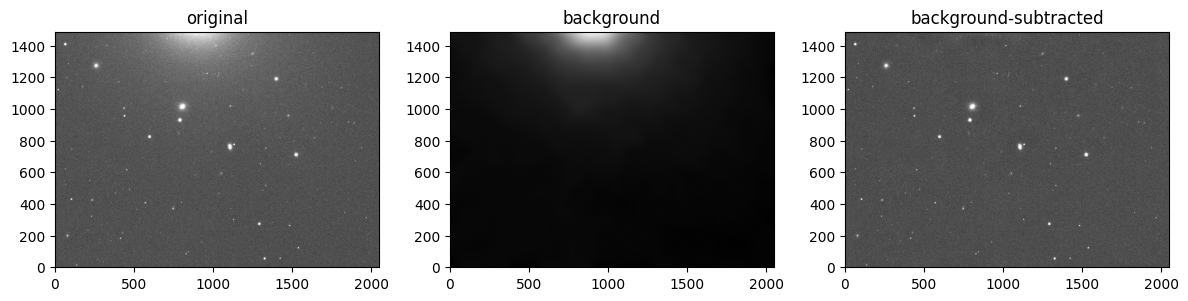

In [12]:
# SEP expects C-contiguous, float32
data = img.copy()
bkg = sep.Background(data, bw=64, bh=64, fw=3, fh=3)
bkg_sub = data - bkg.back()
bkg_rms = bkg.rms()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(data, origin='lower', cmap='gray', norm=norm); plt.title('original')
plt.subplot(1,3,2); plt.imshow(bkg.back(), origin='lower', cmap='gray'); plt.title('background')
plt.subplot(1,3,3); plt.imshow(bkg_sub, origin='lower', cmap='gray', norm=norm); plt.title('background-subtracted')
plt.tight_layout(); plt.show()

### 4. Source detection, center estimate, & star/compact-source mask
- Detects sources with SEP on the background-subtracted image.
- Picks a galaxy center guess from the brightest/largest detection.
- Builds an elliptical mask around other sources (likely stars/compact galaxies), grown by a factor to be safe.

In [13]:
objects = sep.extract(bkg_sub, thresh=2.0, err=bkg_rms, minarea=10)

# crude guess of galaxy center: pick the largest object by area/flux
idx = np.argmax(objects['flux'])
x0, y0 = objects['x'][idx], objects['y'][idx]

# build a mask for obvious stars/compact sources (exclude the big one we think is the galaxy)
mask = np.zeros_like(bkg_sub, dtype=bool)
for i, obj in enumerate(objects):
    if i == idx:
        continue
    a, b, theta = obj['a'], obj['b'], obj['theta']
    # Grow the mask a bit:
    ra, rb = 2.5*a, 2.5*b
    yy, xx = np.indices(img.shape)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    dx, dy = xx - obj['x'], yy - obj['y']
    r = ((dx*cos_t + dy*sin_t)**2)/(ra**2) + ((dy*cos_t - dx*sin_t)**2)/(rb**2)
    mask |= (r <= 1.0)

# Also mask obvious negative/NaN pixels
mask |= ~np.isfinite(bkg_sub)

### 5. Optional light smoothing
- Applies a small Gaussian blur (σ ≈ 1 px) to the background-subtracted image.
- Replaces masked pixels with NaN to exclude them from fitting.

In [14]:
sm = convolve(bkg_sub, Gaussian2DKernel(x_stddev=1.0))
data_for_fit = np.where(mask, np.nan, sm)

### 6. Ellipse fitting: configuration & run
- Sets the pixel scale $s=0.396''/\text{px}$.
- Defines the radial range: start just beyond 1 arcsec to avoid seeing, aim for $\sim 100''$ if S/N allows.
- Initializes ellipse geometry (center, ellipticity, PA) and runs Ellipse.fit_image.

In [15]:
s = 0.396  # arcsec/pix
r_min_pix = int(np.ceil(1.0 / s))       # > 1 arcsec
r_max_pix = int(np.floor(100.0 / s))    # ~100 arcsec
step = 1.10  # multiplicative radial step

# Initial ellipse geometry
geom = EllipseGeometry(x0=x0, y0=y0, sma=r_min_pix, eps=0.2, pa=np.deg2rad(0.0))

ellipse = Ellipse(data_for_fit, geometry=geom)
isolist = ellipse.fit_image(minsma=r_min_pix, maxsma=r_max_pix, step=step, 
                            linear=False, conver=0.05, maxgerr=0.5)

ValueError: cannot convert float NaN to integer

### 7. Extract 1D isophotal profile arrays
- Pulls semi-major axis radii (pixels), mean intensities (nanomaggies per pixel), and per-annulus errors from the isophote list.
- Removes NaNs/zeros and converts radii to arcsec.

In [ ]:
sma_pix = np.array([iso.sma for iso in isolist])        # semi-major axis [pixels]
intens = np.array([iso.intens for iso in isolist])      # nanomaggies/pixel
ierr   = np.array([iso.int_err for iso in isolist])     # per-pixel uncertainty
good = np.isfinite(intens) & np.isfinite(ierr) & (ierr > 0)
sma_pix, intens, ierr = sma_pix[good], intens[good], ierr[good]
r_arcsec = sma_pix * s

### 8. Convert intensities to surface brightness (mag arcsec$^{-2}$) + errors
- Converts per pixel intensity to per arcsec$^2$ via division by $s^2$.
- Applies Pogson conversion to get $\mu_g$ (mag arcsec$^{-2}$).
- Propagates errors: $$\sigma_\mu \approx \frac{2.5}{\ln{10}} \frac{\sigma_I}{I}$$ where the area factor cancels in the ratio.

In [ ]:
# per arcsec^2 = per pixel / s^2
I_arc = intens / (s**2)
mu = 22.5 - 2.5*np.log10(I_arc)
mu_err = (2.5/np.log(10)) * (ierr/(intens))  # same area factor cancels

### 9. Quick-look plot of the SB profile
- Plots $\mu_g$ vs. $r$ (arcsec) with error bars.
- Inverts the y-axis (brighter at the top) as customary for SB plots.

In [ ]:
plt.figure(figsize=(6,4))
plt.errorbar(r_arcsec, mu, yerr=mu_err, fmt='.', ms=3)
plt.gca().invert_yaxis()
plt.xlabel('Semi-major axis r  [arcsec]')
plt.ylabel(r'$\mu_g$  [mag arcsec$^{-2}$]')
plt.title('NGC 4467 — SB profile (g)')
plt.show()

### 10. Define Sérsic model & fit $(\mu_e, R_e, n)$ with uncertainties
- Implements $b_n(n)$ and the Sérsic $\mu(r)$ model in magnitude units.
- Fits the model to the selected radial range using scipy.optimize.curve_fit, with data uncertainties for proper weighting.
- Returns best-fit parameters and their 1σ errors from the covariance matrix.

In [ ]:
from scipy.optimize import curve_fit

def b_n(n):
    return 2.0*n - 1.0/3.0 + 0.009876/n

def mu_sersic(r, mu_e, Re, n):
    return mu_e + 1.0857 * b_n(n) * ((r/Re)**(1.0/n) - 1.0)

# optional: clip extreme radii by S/N
sel = (r_arcsec > 1.0)  # you can also limit max radius by S/N if needed
x, y, yerr = r_arcsec[sel], mu[sel], mu_err[sel]

p0 = (np.nanmedian(mu[(r_arcsec>2)&(r_arcsec<5)]), 5.0, 2.0)  # rough guess
bounds = ([10.0, 0.2, 0.2], [30.0, 200.0, 8.0])

popt, pcov = curve_fit(mu_sersic, x, y, p0=p0, sigma=yerr, absolute_sigma=True, bounds=bounds, maxfev=50000)
mu_e_fit, Re_fit, n_fit = popt
perr = np.sqrt(np.diag(pcov))
mu_e_err, Re_err, n_err = perr

# goodness-of-fit
resid = y - mu_sersic(x, *popt)
chi2 = np.sum((resid/yerr)**2)
dof = len(x) - len(popt)
chi2_red = chi2 / dof

# Plot
xx = np.linspace(x.min(), x.max(), 400)
plt.figure(figsize=(6,4))
plt.errorbar(x, y, yerr=yerr, fmt='.', ms=3, label='data')
plt.plot(xx, mu_sersic(xx, *popt), '-', label=f"Sérsic fit: n={n_fit:.2f}, Re={Re_fit:.1f}\"")
plt.gca().invert_yaxis()
plt.xlabel('r [arcsec]'); plt.ylabel(r'$\mu_g$ [mag arcsec$^{-2}$]')
plt.legend(); plt.title(f'NGC 4467 — Sérsic fit (χ²_red={chi2_red:.2f})')
plt.show()

### 11. Compute central surface brightness $\mu_0$
- Uses the Sérsic identity: $$\mu_0=\mu_e - 1.0857 b_n (n)$$ to extrapolate the central SB (mag arcsec $^{-2}$).

In [ ]:
mu0 = mu_e_fit - 1.0857 * b_n(n_fit)

### 12. Total apparent flux and magnitude $m_g$ (large elliptical aperture)
- Selects a representative outer isophote for geometry (center, PA, ellipticity).
- Performs elliptical aperture photometry out to a semi-major axis that encloses essentially all light in the frame (within reason).
- Converts total nanomaggies to apparent magnitude $m_g$.

In [ ]:
# choose an outer isophote as geometry template (e.g., ~80-100")
iso_outer = isolist[-5]  # adjust if the last few are noisy
x0, y0 = iso_outer.x0, iso_outer.y0
eps, pa = iso_outer.eps, iso_outer.pa
b_over_a = 1.0 - eps

a_ap_pix = int(min(iso_outer.sma*1.05, r_max_pix))  # small safety margin
ap = EllipticalAperture((x0, y0), a_ap_pix, a_ap_pix*b_over_a, theta=pa)
flux_tot = ap.do_photometry(bkg_sub, method='exact', mask=mask)[0][0]  # nanomaggies
m_app = 22.5 - 2.5*np.log10(flux_tot)
print("Total apparent g magnitude:", m_app)

### 13. Convert $R_e$ from arcsec to kpc
- Converts the effective radius to physical units with: $$1"=0.004848 \, D_{Mpc} \, kpc, R_{e,kpc}=R_{e,arcsec} \times 0.004848 \times D_{Mpc}$$

In [ ]:
D_Mpc = ...  # fill in
Re_kpc = Re_fit * 0.004848 * D_Mpc

### 14. Plot

In [ ]:
plt.figure(figsize=(6,3))
plt.scatter(x, resid, s=6)
plt.axhline(0, color='k', lw=1)
plt.xlabel('r [arcsec]'); plt.ylabel('Δμ (data - model) [mag/arcsec²]')
plt.title('Residuals (Sérsic)')
plt.show()

### 15. Residual diagnostics & 2D model sanity check
- Plots 1D residuals $Δ𝜇$ vs. radius to reveal systematic deviations from the model.
- Builds a 2D ellipse-based model from the isophotes and shows data / model / residual images side-by-side.

In [ ]:
model = build_ellipse_model(data_for_fit.shape, isolist)
resid2d = data_for_fit - model
plt.figure(figsize=(12,4))
for i,(im,t) in enumerate([(data_for_fit,'data'), (model,'model'), (resid2d,'residual')]):
    plt.subplot(1,3,i+1); plt.imshow(im, origin='lower', cmap='gray', norm=norm); plt.title(t)
plt.tight_layout(); plt.show()